# If runnning on Collab, import datasets on drive and run next cells:

In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/juliet.csv')

# If not running on Collab, run this cells:

In [ ]:
df = pd.read_csv('juliet.csv')

# Making a dataset with 30.000 vuln functions and 30.000 non-vuln functions

In [ ]:
df_good = df[df['ast'].str.contains("FileAST")]

In [ ]:
df_bad = df[~df['ast'].str.contains("FileAST")]

In [ ]:
print(df.shape)

(92672, 7)


In [ ]:
print(df_good[df_good['is_vuln'] == True].shape)

(30375, 7)


In [ ]:
print(df_good[df_good['is_vuln'] == False].shape)

(55579, 7)


In [ ]:
df_true = df_good[df_good['is_vuln'] == True].sample(n=30000, random_state=42)
df_false = df_good[df_good['is_vuln'] == False].sample(n=30000, random_state=42)

df_test = pd.concat([df_true, df_false]).reset_index(drop=True)

In [ ]:
print(df_test.shape)

(60000, 7)


# TRAIN CLASSICAL ML MODELS WITH VECTORIZERS

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

def run_text_classification_experiments(df_test):
    tqdm.pandas()

    df_test['ast_str'] = df_test['ast'].apply(str)

    X = df_test['ast_str']
    y = df_test['is_vuln']

    vectorizers = {
        'Count': CountVectorizer(),
        'TFIDF': TfidfVectorizer(),
        'Hashing': HashingVectorizer(n_features=10000)
    }

    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
        'KNN': KNeighborsClassifier(),
        'LogReg L1': LogisticRegression(penalty='l1', solver='liblinear', random_state=42),
        'LogReg L2': LogisticRegression(penalty='l2', solver='liblinear', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }

    for vec_name, vectorizer in tqdm(vectorizers.items(), desc="Vectorizers"):
        print(f"\n=== Using {vec_name} Vectorizer ===")
        X_vec = vectorizer.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

        for clf_name, clf in tqdm(classifiers.items(), desc=f"{vec_name} Classifiers", leave=False):
            print(f"\n--- Classifier: {clf_name} ---")
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            print(classification_report(y_test, y_pred))

In [ ]:
run_text_classification_experiments(df_test)

# RUN THE CNN + LSTM model

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam


def run_cnn_lstm_model(df_test, max_words=15000, max_len=1000, embedding_dim=128, epochs=50):
    df_test['ast_str'] = df_test['ast'].astype(str)
    X_raw = df_test['ast_str']
    y = df_test['is_vuln'].astype(int)

    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_raw)
    sequences = tokenizer.texts_to_sequences(X_raw)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, y, test_size=0.2, random_state=42
    )

    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        Conv1D(filters=512, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(256),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        callbacks=callbacks
    )

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    return model, history

In [ ]:
model, history = run_cnn_lstm_model(df_test)

/usr/local/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 109ms/step - accuracy: 0.5373 - loss: 0.6854 - val_accuracy: 0.5396 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.5786 - loss: 0.6506 - val_accuracy: 0.9115 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 84s 114ms/step - accuracy: 0.9207 - loss: 0.1755 - val_accuracy: 0.9475 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 114ms/step - accuracy: 0.9471 - loss: 0.1072 - val_accuracy: 0.9581 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 114ms/step - accuracy: 0.9648 - loss: 0.0757 - val_accuracy: 0.9715 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 114ms/step - accuracy: 0.9728 - loss: 0.0572 - val_accuracy: 0.9717 - val_loss: 0.0610 - learning_rate: 0.0010
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 80s 111ms/step - accuracy: 0.9

# PLOT ACCURACY AND LOSS

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

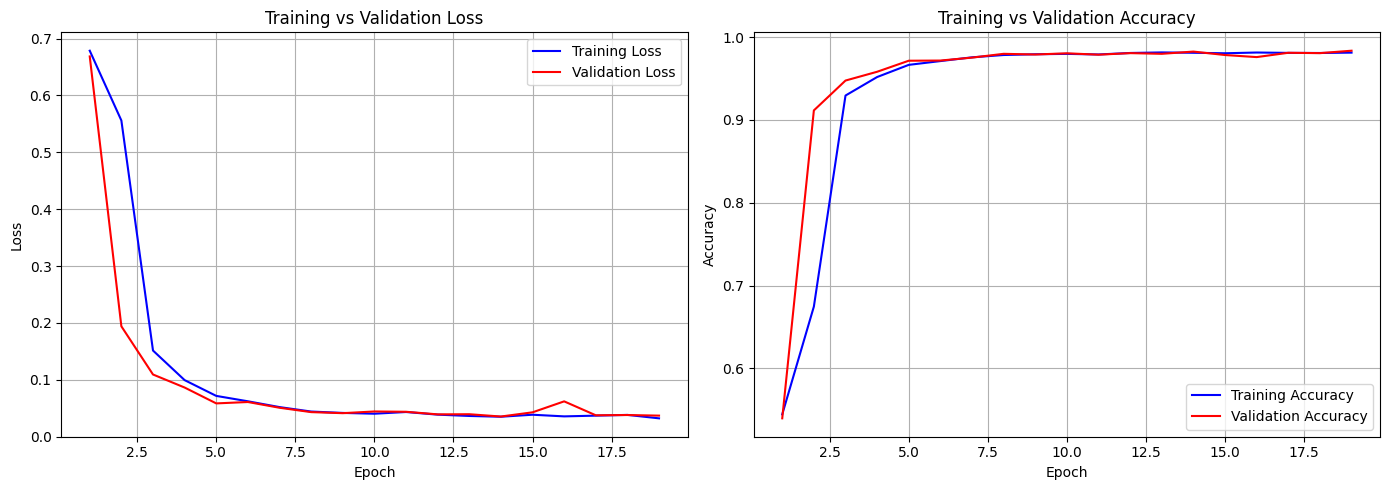

In [ ]:
plot_training_history(history)

# RUN THE CNN MODEL

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def run_cnn_model(df_test, max_words=15000, max_len=1000, embedding_dim=128, epochs=50):
    df_test['ast_str'] = df_test['ast'].astype(str)
    X_raw = df_test['ast_str']
    y = df_test['is_vuln'].astype(int)

    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_raw)
    sequences = tokenizer.texts_to_sequences(X_raw)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, y, test_size=0.2, random_state=42
    )

    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        Conv1D(filters=512, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        callbacks=callbacks
    )

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    return model, history

In [ ]:
model, history = run_cnn_model(df_test)

/usr/local/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.8286 - loss: 0.3383 - val_accuracy: 0.9502 - val_loss: 0.1157 - learning_rate: 0.0010
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.9458 - loss: 0.1191 - val_accuracy: 0.9506 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9532 - loss: 0.1017 - val_accuracy: 0.9535 - val_loss: 0.0945 - learning_rate: 0.0010
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9596 - loss: 0.0867 - val_accuracy: 0.9644 - val_loss: 0.0746 - learning_rate: 0.0010
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.9625 - loss: 0.0808 - val_accuracy: 0.9696 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.9633 - loss: 0.0765 - val_accuracy: 0.9704 - val_loss: 0.0676 - learning_rate: 0.0010
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.9651 - l

# PLOT ACCURACY AND LOSS

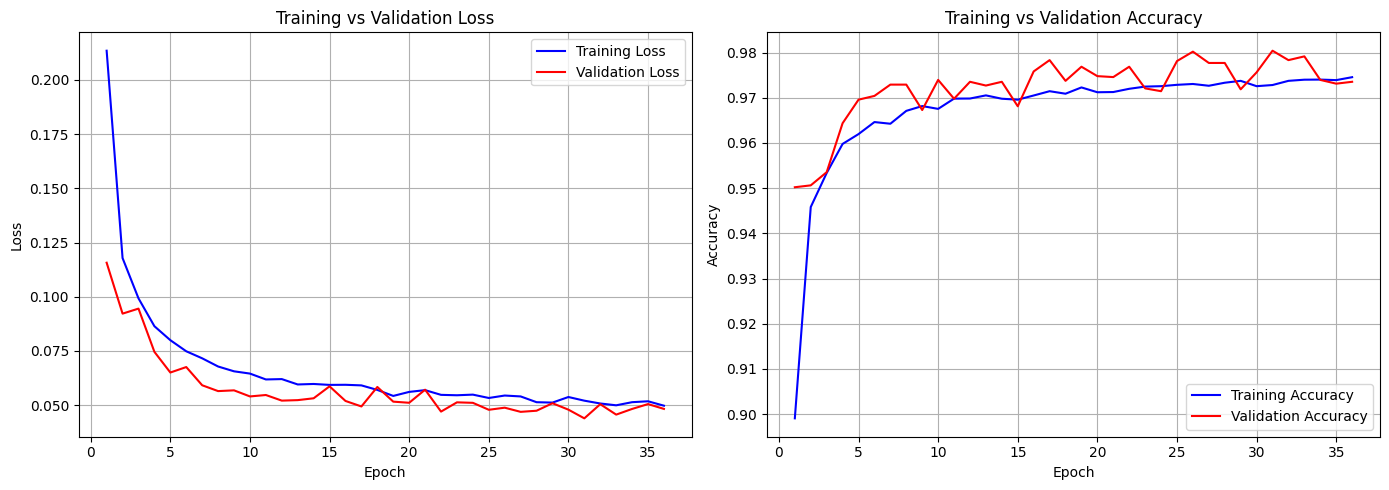

In [ ]:
plot_training_history(history)

# TRANSFORM FUNCTIONS INTO GRAPHS AND RUN GNN MODEL

In [ ]:
import re

def rename_func_to_generic(code):
    return re.sub(r'void\s+\w+\s*\(', 'void function(', code, count=1)

df_test['function_code_generic'] = df_test['function_code'].apply(rename_func_to_generic)

In [ ]:
from pycparser import c_parser
import re
from tqdm import tqdm

parser = c_parser.CParser()
asts = []

typedef_fix = "typedef unsigned int size_t;\n"
typedef_file = "typedef struct _FILE FILE;\n"
typedef_handle = "typedef struct _HANDLE HANDLE;\n"
typedef_hwinsta = "typedef struct _HWINSTA HWINSTA;\n"
typedef_bool = "typedef int BOOL;\n"


for code in tqdm(df_test['function_code_generic']):
    try:
        clean_code = re.sub(r'//.*?$|/\*.*?\*/', '', code, flags=re.DOTALL | re.MULTILINE)
        clean_code = re.sub(r'WSADATA', 'struct WSADATA', clean_code)
        clean_code = re.sub(r'SOCKET', 'int', clean_code)
        clean_code = re.sub(r'INVALID_SOCKET', '-1', clean_code)
        clean_code = re.sub(r'wchar_t', 'char', clean_code)
        clean_code = re.sub(r'int64_t', 'int', clean_code)
        clean_code = re.sub(r'twoIntsStruct', 'struct', clean_code)
        clean_code = re.sub(r'structSigAtomic', 'struct', clean_code)
        clean_code = re.sub(r'^.*CWE.* myStruct;$', 'struct myStruct;', clean_code, flags=re.MULTILINE)
        clean_code = re.sub(r'^.*CWE.* myUnion;$', 'union myUnion;', clean_code, flags=re.MULTILINE)
        clean_code = '\n'.join(line for line in clean_code.splitlines() if not line.strip().startswith('#'))
        clean_code = typedef_fix + typedef_file + typedef_handle + typedef_hwinsta + typedef_bool + clean_code

        ast = parser.parse(clean_code)
        asts.append(ast)
    except Exception as e:
        asts.append(str(e) + '\n' + clean_code)

df_test['ast'] = asts

100%|██████████| 60000/60000 [03:18<00:00, 302.69it/s]


In [ ]:
print(df_test['ast'][0])

FileAST(ext=[Typedef(name='size_t',
                     quals=[
                           ],
                     storage=['typedef'
                             ],
                     type=TypeDecl(declname='size_t',
                                   quals=[
                                         ],
                                   align=None,
                                   type=IdentifierType(names=['unsigned',
                                                              'int'
                                                             ]
                                                       )
                                   )
                     ),
             Typedef(name='FILE',
                     quals=[
                           ],
                     storage=['typedef'
                             ],
                     type=TypeDecl(declname='FILE',
                                   quals=[
                                         ],
                  

In [ ]:
from pycparser import c_ast
from torch_geometric.data import Data
import torch

def pycparser_ast_to_graph(ast_root):
    nodes = []
    edges = []

    def visit(node, parent_idx):
        cur_idx = len(nodes)
        nodes.append(node)
        if parent_idx is not None:
            edges.append((parent_idx, cur_idx))
        for child_name, child in node.children():
            visit(child, cur_idx)

    visit(ast_root, None)

    node_types = list(set(type(n).__name__ for n in nodes))
    type_to_idx = {t: i for i, t in enumerate(node_types)}
    x = torch.tensor([[type_to_idx[type(n).__name__]] for n in nodes], dtype=torch.float)

    if len(edges) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

In [ ]:
graph_list = []

for ast_tree, label in zip(df_test['ast'], df_test['is_vuln']):
    try:
        data = pycparser_ast_to_graph(ast_tree)
        data.y = torch.tensor([label])
        graph_list.append(data)
    except Exception as e:
        print("Error converting AST:", e)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | Train Loss: 906.4489 | Train Acc: 0.67 | Val Loss: 200.2096 | Val Acc: 0.72 | Train F1: 0.68 | Val F1: 0.74
Epoch 02 | Train Loss: 807.3354 | Train Acc: 0.72 | Val Loss: 191.3648 | Val Acc: 0.73 | Train F1: 0.74 | Val F1: 0.78
Epoch 03 | Train Loss: 752.4066 | Train Acc: 0.74 | Val Loss: 176.0909 | Val Acc: 0.75 | Train F1: 0.76 | Val F1: 0.79
Epoch 04 | Train Loss: 705.9289 | Train Acc: 0.76 | Val Loss: 157.0237 | Val Acc: 0.79 | Train F1: 0.77 | Val F1: 0.80
Epoch 05 | Train Loss: 659.1562 | Train Acc: 0.78 | Val Loss: 147.2731 | Val Acc: 0.80 | Train F1: 0.78 | Val F1: 0.81
Epoch 06 | Train Loss: 617.7190 | Train Acc: 0.79 | Val Loss: 137.9505 | Val Acc: 0.81 | Train F1: 0.79 | Val F1: 0.80
Epoch 07 | Train Loss: 590.8623 | Train Acc: 0.80 | Val Loss: 130.5284 | Val Acc: 0.83 | Train F1: 0.81 | Val F1: 0.84
Epoch 08 | Train Loss: 565.5819 | Train Acc: 0.81 | Val Loss: 129.8467 | Val Acc: 0.83 | Train F1: 0.81 | Val F1: 0.84
Epoch 09 | Train Loss: 548.8745 | Train Acc: 0.8

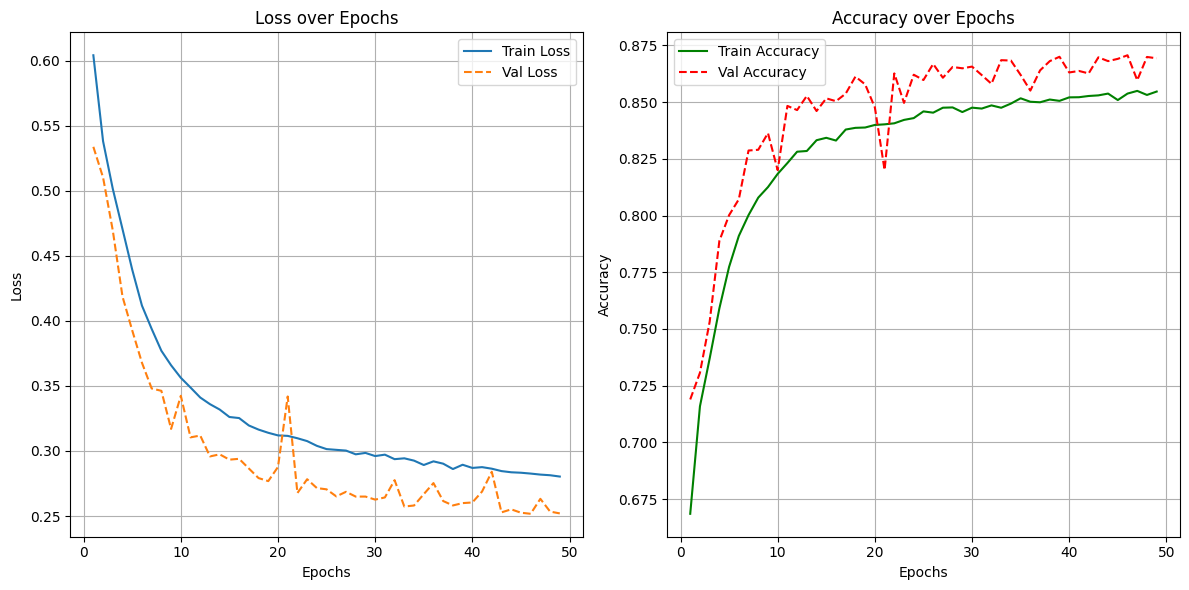

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

def ast_to_graph(ast_root, type_to_idx):
    nodes = []
    edges = []

    def visit(node, parent_idx):
        cur_idx = len(nodes)
        nodes.append(node)
        if parent_idx is not None:
            edges.append((parent_idx, cur_idx))
        for _, child in node.children():
            visit(child, cur_idx)

    visit(ast_root, None)

    node_indices = [type_to_idx[type(n).__name__] for n in nodes]
    x = F.one_hot(torch.tensor(node_indices), num_classes=len(type_to_idx)).float()
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    return Data(x=x, edge_index=edge_index)

all_types = set()
for tree in df_test['ast']:
    def collect_types(node):
        all_types.add(type(node).__name__)
        for _, child in node.children():
            collect_types(child)
    collect_types(tree)

type_to_idx = {t: i for i, t in enumerate(sorted(all_types))}

graph_list = []
for tree, label in zip(df_test['ast'], df_test['is_vuln']):
    try:
        data = ast_to_graph(tree, type_to_idx)
        data.y = torch.tensor([label], dtype=torch.long)
        graph_list.append(data)
    except Exception as e:
        print("AST error:", e)

labels = [d.y.item() for d in graph_list]
train_graphs, val_graphs = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)

weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(weights, dtype=torch.float)

class GCN_LSTM_Dropout(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, lstm_hidden_size, num_layers=3, out_channels=2, dropout=0.5):
        super(GCN_LSTM_Dropout, self).__init__()

        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()

        self.convs.append(GCNConv(in_channels, hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.gcn_dropout = torch.nn.Dropout(dropout)
        self.lstm = torch.nn.LSTM(hidden_channels, lstm_hidden_size, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(lstm_hidden_size, out_channels)
        self.fc_dropout = torch.nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index).relu()

        x = self.gcn_dropout(x)
        x = global_mean_pool(x, batch)
        x = x.unsqueeze(1)
        lstm_out, (hn, cn) = self.lstm(x)

        out = self.fc(hn[-1])  # hn[-1] is the final hidden state of the LSTM

        out = self.fc_dropout(out)

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_LSTM_Dropout(in_channels=len(type_to_idx), hidden_channels=512, lstm_hidden_size=256, num_layers=3, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

early_stopping_patience = 10
best_val_f1 = 0
epochs_without_improvement = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, 50):
    model.train()
    total_train_loss = 0
    all_train_preds, all_train_labels = [], []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()

        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(labels)

    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_precision = precision_score(all_train_labels, all_train_preds, zero_division=0)
    train_recall = recall_score(all_train_labels, all_train_preds, zero_division=0)
    train_f1 = f1_score(all_train_labels, all_train_preds, zero_division=0)

    model.eval()
    total_val_loss = 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y)
            total_val_loss += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            all_val_preds.extend(preds)
            all_val_labels.extend(labels)

    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(all_val_labels, all_val_preds, zero_division=0)
    val_recall = recall_score(all_val_labels, all_val_preds, zero_division=0)
    val_f1 = f1_score(all_val_labels, all_val_preds, zero_division=0)

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_acc)
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_gcn_lstm_dropout_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break

    scheduler.step(total_val_loss)
    print(f"Epoch {epoch:02d} | Train Loss: {total_train_loss:.4f} | Train Acc: {train_acc:.2f} | "
          f"Val Loss: {total_val_loss:.4f} | Val Acc: {val_acc:.2f} | Train F1: {train_f1:.2f} | "
          f"Val F1: {val_f1:.2f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy', color='red', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
